In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
test_df = pd.read_csv("DataSet/HAM.csv")
test_df['image_id'] = test_df['image_id'].apply(lambda x: x + ".jpg")
test_df['image_id'] = 'DataSet/Combined/' + test_df['image_id']

img_size = (200, 200)
batch_size = 16

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_id',
    y_col='dx',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Make sure to set shuffle to False for proper labeling
)

Found 49000 validated image filenames belonging to 7 classes.


In [23]:
model = load_model('Final_InceptionV3_model.h5')

In [27]:
# Make predictions using the loaded model
predictions = model.predict(test_generator)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

3063/3063 [==============================] - 184s 60ms/step


In [28]:
# Define a dictionary to map numerical predictions to labels
label_map = {0: 'AKIEC', 1: 'BCC', 2: 'BKL', 3: 'DF', 4: 'MEL', 5: 'NV', 6: 'VASC'}

# Map predicted classes to labels using the label_map dictionary
predicted_labels = [label_map[pred] for pred in predicted_classes]

# Add predicted labels to the test_df DataFrame
test_df['predicted_dx'] = predicted_labels

# Create the check column ignoring case
test_df['check'] = (test_df['dx'].str.lower() == test_df['predicted_dx'].str.lower()).astype(int)

# Create a new DataFrame with the desired columns
result_df = test_df[['image_id', 'dx', 'predicted_dx', 'check']]

# Save the result DataFrame to a CSV file
result_df.to_csv('results_inception.csv', index=False)

In [29]:
# Group by 'dx' (original type of skin lesion) and 'check' columns and count occurrences
count_df = result_df.groupby(['dx','check']).size().unstack(fill_value=0)

# Print the count DataFrame
print(count_df)

check    0     1
dx              
akiec  245  6755
bcc    231  6769
bkl    516  6484
df     239  6761
mel    151  6849
nv     286  6714
vasc   200  6800


In [26]:
# Group by 'dx' (original type of skin lesion) and 'check' columns and count occurrences
count_df = result_df.groupby(['dx','check']).size().unstack(fill_value=0)

# Print the count DataFrame
print(count_df)

check    0     1
dx              
akiec  245  6755
bcc    231  6769
bkl    516  6484
df     239  6761
mel    151  6849
nv     286  6714
vasc   200  6800


In [60]:
# Make predictions
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

3063/3063 [==============================] - 326s 104ms/step


In [61]:
# Get the true labels from the test generator
true_labels = test_generator.classes

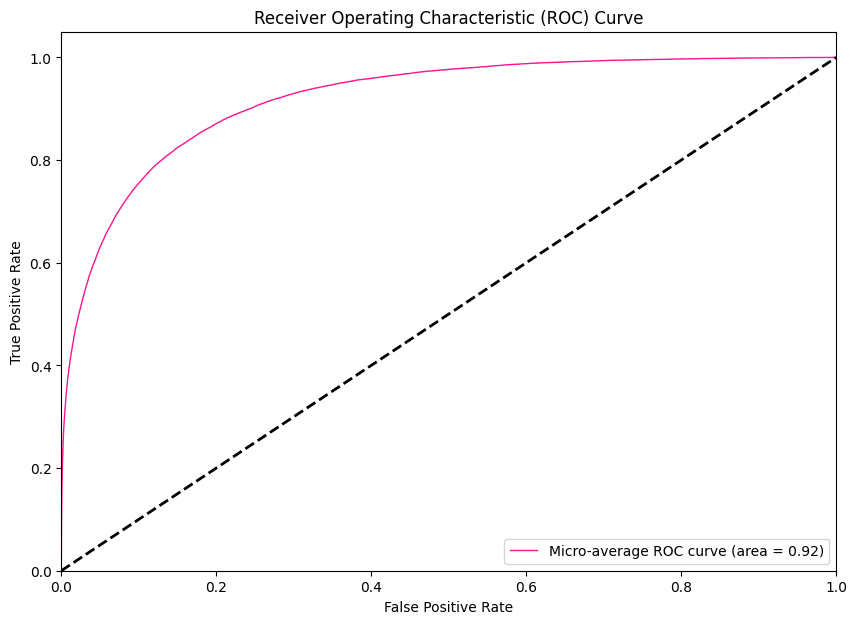

In [62]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Convert true_labels to binary format
binary_true_labels = np.eye(7)[true_labels]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(binary_true_labels[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(binary_true_labels[:, i], predictions[:, i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(binary_true_labels.ravel(), predictions.ravel())
roc_auc["micro"] = roc_auc_score(binary_true_labels, predictions, multi_class='ovr')


# Plot ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle='-', linewidth=1)

# colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown']
# for i, color in zip(range(7), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=2,
#              label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1.0], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Apply threshold of 0.2 for predictions
threshold = 0.9
predicted_labels_threshold = (predictions > threshold).astype(int)


AUC for class 0: 0.8730
AUC for class 1: 0.9130
AUC for class 2: 0.8516
AUC for class 3: 0.9262
AUC for class 4: 0.9015
AUC for class 5: 0.9771
AUC for class 6: 0.9692


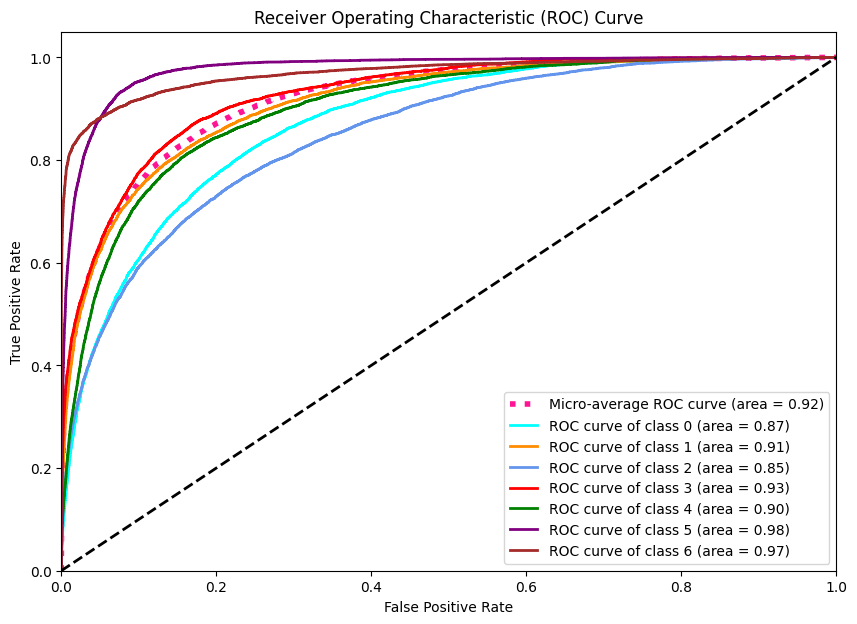

In [63]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Convert true_labels to binary format
binary_true_labels = np.eye(7)[true_labels]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(binary_true_labels[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(binary_true_labels[:, i], predictions[:, i])
    print(f'AUC for class {i}: {roc_auc[i]:.4f}')

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(binary_true_labels.ravel(), predictions.ravel())
roc_auc["micro"] = roc_auc_score(binary_true_labels, predictions, multi_class='ovr')

# Plot ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown']
for i, color in zip(range(7), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Apply threshold of 0.2 for predictions
threshold = 0.2
predicted_labels_threshold = (predictions > threshold).astype(int)

In [64]:
confusion = confusion_matrix(true_labels, predicted_labels)

In [65]:
# Set the print options to display values up to four decimal places
np.set_printoptions(precision=4)

# Print the confusion matrix
print(confusion)

[[3215 1033 1074  805  539  309   25]
 [ 530 4568  587  631  241  384   59]
 [ 596  490 3745  546  575 1039    9]
 [ 605  495  471 4898  337  162   32]
 [ 372  197  848  208 3635 1690   50]
 [  16   33  169   37  139 6601    5]
 [ 131  277  207  884  144  195 5162]]


In [66]:
report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

       akiec       0.59      0.46      0.52      7000
         bcc       0.64      0.65      0.65      7000
         bkl       0.53      0.54      0.53      7000
          df       0.61      0.70      0.65      7000
         mel       0.65      0.52      0.58      7000
          nv       0.64      0.94      0.76      7000
        vasc       0.97      0.74      0.84      7000

    accuracy                           0.65     49000
   macro avg       0.66      0.65      0.65     49000
weighted avg       0.66      0.65      0.65     49000



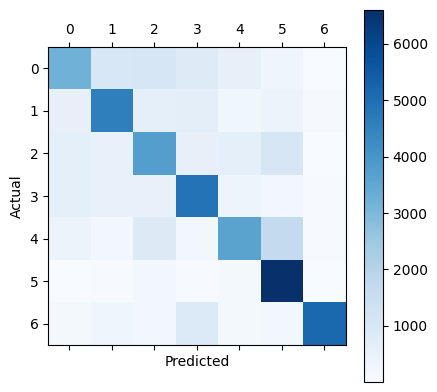

In [67]:
plt.matshow(confusion, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()